In [1]:
%pylab inline
from skimage import measure, morphology, segmentation
import imageio
import ipywidgets as wdg
import skan

Populating the interactive namespace from numpy and matplotlib


/home/maxc/anaconda3/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


In [2]:
img = array(imageio.mimread("/media/maxc/Data/Tomography/Time_Series/PZ103/Subtractions/PZ103_01-20.tif"))

<IPython.core.display.Javascript object>


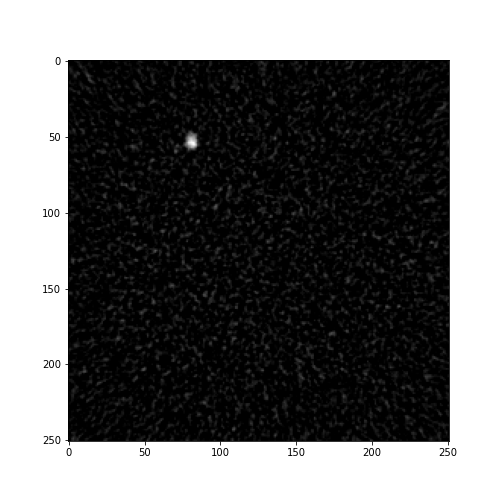

In [3]:
%matplotlib notebook
fig = figure(figsize=(7,7))
z = 200
imshow(img[z], cmap="gray")
x = 0; y = 0
def onclick(event):
    global x
    global y
    close()
    x = int(floor(event.xdata))
    y = int(floor(event.ydata))

ka = fig.canvas.mpl_connect('button_press_event', onclick)

In [4]:
grayselected = img[z, y, x]
graythresh = 390

In [5]:
mask = img >= graythresh

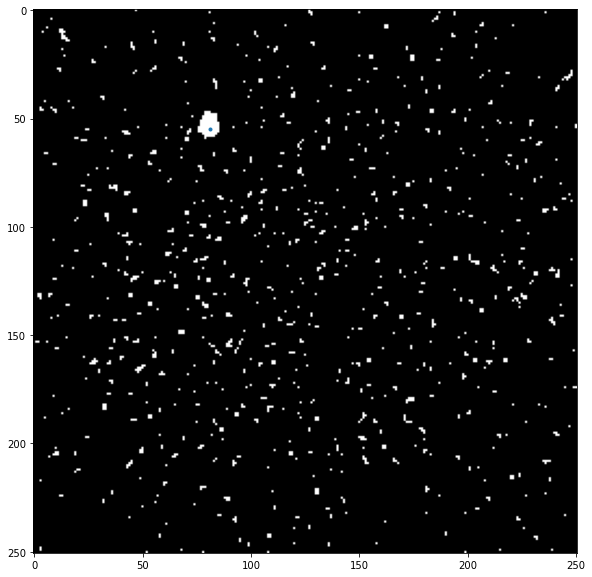

In [6]:
%matplotlib inline
fig = figure(figsize=(10,10))
imshow(mask[z], cmap="gray")
plot(x, y, ".")
show()

In [7]:
whmask = segmentation.flood(mask, (z, y, x))

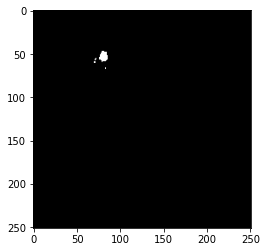

In [8]:
imshow(whmask[z], cmap="gray")
show()

In [9]:
vox_vol = whmask.sum()
vox_size = 169
print("Wormhole volume: " + str(vox_vol*vox_size**3/1000**3/10**3)) # Volume in cm^3
#print(11.5*pi*(3.83/2)**2) # Volume of sample
#print(981*251*251*vox_size**3/1000**3/10**3) # Volume of scan

Wormhole volume: 0.5741392769320001


In [10]:
def surface_area_legland(bimg, voxel_size=30):
    assert len(bimg.shape) == 3, "bimg should be a volume"
    vol = bimg.sum()

    # weights for each direction
    w = zeros(13)
    w[0:3] = 0.04577789120476 * 2
    w[3:9] = 0.03698062787608 * 2
    w[9:] =  0.03519563978232 * 2

    # number of connected components in different directions
    nc = zeros(13)
    
    # primary perpendicular planes
    nc[0] = vol - logical_and(bimg[:,:-1,:], bimg[:,1:,:]).sum()

    nc[1] = vol - logical_and(bimg[:-1,:,:], bimg[1:,:,:]).sum()
    nc[2] = vol - logical_and(bimg[:,:,:-1], bimg[:,:,1:]).sum()

    d1 = 1; d2 = 1; d3 = 1;
    #return 4./3 * d1*d2*d3*(nc[0]/d1 + nc[1]/d2 + nc[2]/d3)
    
    # plane diagonals
    nc[3] = vol - logical_and(bimg[1:,:-1,:], bimg[:-1,1:,:]).sum()
    nc[4] = vol - logical_and(bimg[:-1,:-1,:], bimg[1:,1:,:]).sum()
    nc[5] = vol - logical_and(bimg[:,1:,:-1], bimg[:,:-1,1:]).sum()
    nc[6] = vol - logical_and(bimg[:,:-1,:-1], bimg[:,1:,1:]).sum()
    nc[7] = vol - logical_and(bimg[1:,:,:-1], bimg[:-1,:,1:]).sum()
    nc[8] = vol - logical_and(bimg[:-1,:,:-1], bimg[1:,:,1:]).sum()

    nc[9] = vol - logical_and(bimg[:-1,:-1,:-1], bimg[1:,1:,1:]).sum()
    nc[10] = vol - logical_and(bimg[1:,:-1,:-1], bimg[:-1,1:,1:]).sum()
    nc[11] = vol - logical_and(bimg[:-1,1:,:-1], bimg[1:,:-1,1:]).sum()
    nc[12] = vol - logical_and(bimg[1:,1:,:-1], bimg[:-1,:-1,1:]).sum()
  
    d12 = hypot(d1, d2); d13 = hypot(d1, d3); d23 = hypot(d2,d3);
    d123 = sqrt(d1**2 + d2**2 + d3**2)
    
    s = 4*d1*d2*d3 * ( nc[0]*w[0]/d1 + nc[1]*w[1]/d2 + nc[2]*w[2]/d3 + \
                      (nc[3] + nc[4])*w[3]/d12 + (nc[5] + nc[6])*w[5]/d13 + (nc[7] + nc[8])*w[7]/d23 + \
                      (nc[9] + nc[10] + nc[11] + nc[12])*w[9]/d123 )

    return s

In [11]:
skel_img = morphology.skeletonize_3d(whmask)

In [12]:
skan.summarize(skan.Skeleton(skel_img))

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-src-2,image-coord-dst-0,image-coord-dst-1,image-coord-dst-2,coord-src-0,coord-src-1,coord-src-2,coord-dst-0,coord-dst-1,coord-dst-2,euclidean-distance
0,1,1,11,5.656854,1,1.0,0.0,110.000000,48.000000,140.000000,114.000000,46.000000,138.000000,110.000000,48.000000,140.000000,114.000000,46.000000,138.000000,4.898979
1,1,4,9,3.000000,1,1.0,0.0,113.000000,35.000000,140.000000,115.714286,36.142857,139.428571,113.000000,35.000000,140.000000,115.714286,36.142857,139.428571,3.000000
2,1,9,120,8.729585,2,1.0,0.0,115.714286,36.142857,139.428571,119.666667,32.000000,141.833333,115.714286,36.142857,139.428571,119.666667,32.000000,141.833333,6.210271
3,1,9,235,7.770360,2,1.0,0.0,115.714286,36.142857,139.428571,120.766667,37.200000,137.300000,115.714286,36.142857,139.428571,120.766667,37.200000,137.300000,5.583451
4,1,9,235,11.019741,2,1.0,0.0,115.714286,36.142857,139.428571,120.766667,37.200000,137.300000,115.714286,36.142857,139.428571,120.766667,37.200000,137.300000,5.583451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,1,3187,16671,8.922936,1,1.0,0.0,408.000000,63.285714,99.714286,410.000000,64.000000,93.000000,408.000000,63.285714,99.714286,410.000000,64.000000,93.000000,7.042147
3977,1,3187,16666,9.747150,1,1.0,0.0,408.000000,63.285714,99.714286,409.000000,68.000000,102.000000,408.000000,63.285714,99.714286,409.000000,68.000000,102.000000,5.333758
3978,1,3189,16685,2.870829,1,1.0,0.0,413.500000,54.500000,101.000000,413.000000,56.000000,99.000000,413.500000,54.500000,101.000000,413.000000,56.000000,99.000000,2.549510
3979,1,3189,16660,9.287881,1,1.0,0.0,413.500000,54.500000,101.000000,409.000000,51.000000,100.000000,413.500000,54.500000,101.000000,409.000000,51.000000,100.000000,5.787918
